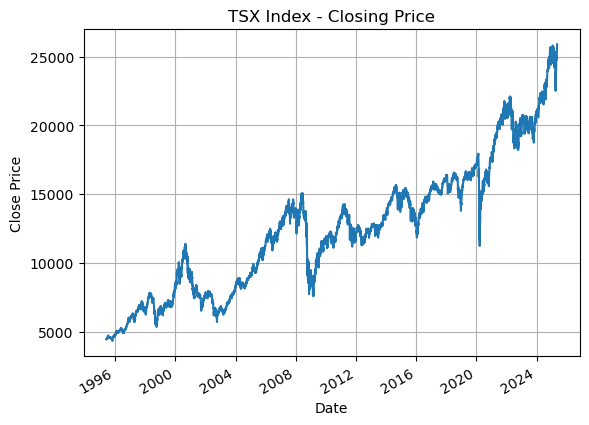

In [1]:
import yfinance as yf
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Retrieve TSX data from Yahoo
TSX = yf.Ticker("^GSPTSE")
end_date = datetime.datetime.today()
start_date = end_date - datetime.timedelta(days=30 * 365)  # ~30 years

TSX = TSX.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

TSX.index = pd.to_datetime(TSX.index)

# Drop unused columns
TSX.drop(columns=["Dividends", "Stock Splits"], inplace=True)

# Compute daily returns
TSX["Returns"] = TSX["Close"].pct_change()

# Create a tomorrow price to set up target variable
TSX["Tomorrow Price"] = TSX["Close"].shift(-1)

# Generated the target variable:
# Target is 1 if tomorrow's closing price is higher than today's, 0 otherwise
# This means our analysis predicts a up or down movement, not specifically the stock price
TSX["Target"] = (TSX["Tomorrow Price"] > TSX["Close"]).astype(int)

# Drop NaNs
TSX.dropna(inplace=True)

# Plot Close price
TSX["Close"].plot(title="TSX Index - Closing Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()


In [2]:
# First Method Used - Random Forest
# Trained to determine if the TSX index will go up or down based on historical data.

# Generate the model, 100 decision trees, min 100 samples to split
# Predictors: Close, Volume, Open, High, Low
# Train on target (previuosly defined)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# Training set all but last 100
train = TSX.iloc[:-100]

# Test set on last 100
test = TSX.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [3]:
def predict(train, test, predictors, model):
    # Train model using historical data
    model.fit(train[predictors], train["Target"])
    
    # Generate predictions on new data
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    
    # Combine actual targets with predictions for performance evaluation
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

# Performs time-series backtesting using a rolling window approach
# Training window ~ 10 years, test set window ~ 1 year
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    # Create rolling training/test windows
    for i in range(start, data.shape[0], step):
        # Training data: All data up to current position
        train = data.iloc[0:i].copy()
        
        # Test data: Next 'step' days after training period
        test = data.iloc[i:(i+step)].copy()
        
        # Generate predictions for current test window
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
        
    return pd.concat(all_predictions, axis=0)

In [4]:
# Run backtest to generate predictions
predictions = backtest(TSX, model, predictors)
predicted_directions = predictions["Predictions"].tolist()

# Show prediction vs actual distributions
print("Model Predictions (1 = UP, 0 = DOWN):")
print(predictions["Predictions"].value_counts())
print("\nActual Market Movement:")
print(predictions["Target"].value_counts())

# Show precision score
precision = precision_score(predictions["Target"], predictions["Predictions"])
print(f"\nPrecision Score (how precise the model is when it predicts that the TSX will go up): {precision:.4f}")


Model Predictions (1 = UP, 0 = DOWN):
Predictions
1    3017
0    2013
Name: count, dtype: int64

Actual Market Movement:
Target
1    2772
0    2258
Name: count, dtype: int64

Precision Score (how precise the model is when it predicts that the TSX will go up): 0.5515


In [5]:
# Second Method Used - LTSM

# Normalize data
from sklearn.preprocessing import MinMaxScaler
import numpy as np

close_prices = TSX[["Close"]].values
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_close = scaler.fit_transform(close_prices)

# Creating Sequences
def create_sequences_with_dates(data, dates, seq_length):
    X = []
    y = []
    seq_dates = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
        seq_dates.append(dates[i])  # associate the label with its date
    return np.array(X), np.array(y), np.array(seq_dates)

SEQ_LENGTH = 60
dates = TSX.index
X, y, sequence_dates = create_sequences_with_dates(normalized_close, dates, SEQ_LENGTH)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
train_dates, test_dates = sequence_dates[:split], sequence_dates[split:]

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define LTSM model

import torch.nn as nn

class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # LSTM output: (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x)
        # Take output from the last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out

Training samples: 5976, Testing samples: 1494


In [6]:
# Initialize model

model = StockLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 30
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")


Epoch 1/30, Loss: 0.008133
Epoch 2/30, Loss: 0.000126
Epoch 3/30, Loss: 0.000131
Epoch 4/30, Loss: 0.000125
Epoch 5/30, Loss: 0.000116
Epoch 6/30, Loss: 0.000134
Epoch 7/30, Loss: 0.000118
Epoch 8/30, Loss: 0.000106
Epoch 9/30, Loss: 0.000104
Epoch 10/30, Loss: 0.000103
Epoch 11/30, Loss: 0.000105
Epoch 12/30, Loss: 0.000102
Epoch 13/30, Loss: 0.000087
Epoch 14/30, Loss: 0.000089
Epoch 15/30, Loss: 0.000089
Epoch 16/30, Loss: 0.000079
Epoch 17/30, Loss: 0.000081
Epoch 18/30, Loss: 0.000090
Epoch 19/30, Loss: 0.000072
Epoch 20/30, Loss: 0.000076
Epoch 21/30, Loss: 0.000073
Epoch 22/30, Loss: 0.000071
Epoch 23/30, Loss: 0.000072
Epoch 24/30, Loss: 0.000062
Epoch 25/30, Loss: 0.000062
Epoch 26/30, Loss: 0.000062
Epoch 27/30, Loss: 0.000068
Epoch 28/30, Loss: 0.000058
Epoch 29/30, Loss: 0.000060
Epoch 30/30, Loss: 0.000058


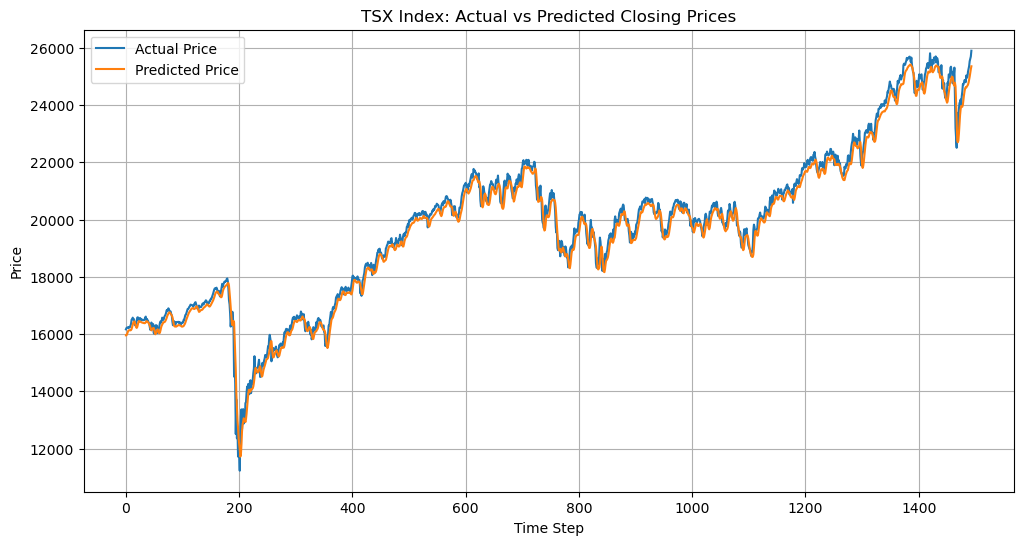

In [7]:
model.eval()
predictions = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        pred = model(X_batch)
        predictions.append(pred)

# Concatenate all batches into a single array
predictions = torch.cat(predictions).numpy()

# Undo normalization
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test)

# Align lengths if needed (in case of batch size rounding)
min_len = min(len(predicted_prices), len(actual_prices))
predicted_prices = predicted_prices[:min_len]
actual_prices = actual_prices[:min_len]

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title('TSX Index: Actual vs Predicted Closing Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

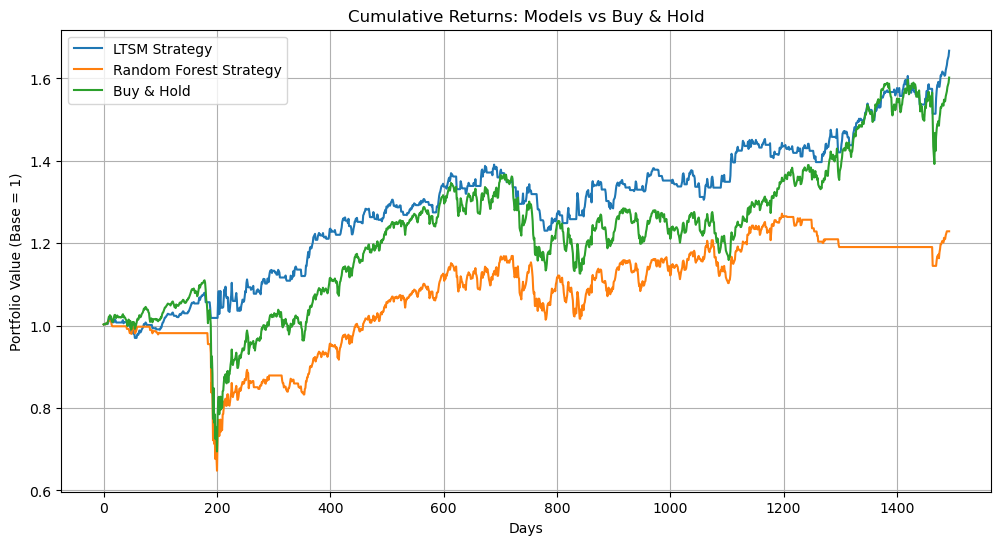

In [13]:
# Simulated returns
strategy_returns_ltsm = []
strategy_returns_rf = []
buy_and_hold_returns = []

initial_price = actual_prices[0]
frame = len(actual_prices)
predicted_directions = predicted_directions[-frame:]

for i in range(1, frame):
    today_price = actual_prices[i-1][0]
    tomorrow_price = actual_prices[i][0]
    predicted_up = predicted_prices[i][0] > predicted_prices[i-1][0]

    if predicted_up:
        daily_return = (tomorrow_price - today_price) / today_price
    else:
        daily_return = 0
    strategy_returns_ltsm.append(daily_return)
    
    if predicted_directions[i]:
        daily_return = (tomorrow_price - today_price) / today_price
    else:
        daily_return = 0
    strategy_returns_rf.append(daily_return)

    bh_return = (tomorrow_price - today_price) / today_price
    buy_and_hold_returns.append(bh_return)


# Cumulative returns
strategy_ltsm_cum = np.cumprod([1 + r for r in strategy_returns_ltsm])
strategy_rf_cum = np.cumprod([1 + r for r in strategy_returns_rf])
bh_cum = np.cumprod([1 + r for r in buy_and_hold_returns])

plt.figure(figsize=(12, 6))
plt.plot(strategy_ltsm_cum, label="LTSM Strategy")
plt.plot(strategy_rf_cum, label="Random Forest Strategy")
plt.plot(bh_cum, label="Buy & Hold")
plt.title("Cumulative Returns: Models vs Buy & Hold")
plt.xlabel("Days")
plt.ylabel("Portfolio Value (Base = 1)")
plt.grid(True)
plt.legend()
plt.savefig("cumulative_returns.png", dpi=300, bbox_inches='tight')
plt.show()
